# **Data Cleaning Notebook**

## Objectives

* Evaluate and manage the missing data
* Clean data
        
## Inputs
        
* outputs/datasets/collection/HousePricesData.csv
        
## Outputs
        
* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned
* Data cleaning pipeline

## Additional comments 

* We will only be dealing with the HousePricesData dataset as the inherited houses dataset does not require analysis, it will only be used to make predictions.


---

## Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/P5-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/P5-heritage-housing-issues'

---

## Import libraries

In [4]:
# load data
import pandas as pd
# data exploration
from pandas_profiling import ProfileReport
# plot and graphs visualisation
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
# Train/test set split
from sklearn.model_selection import train_test_split
# Data cleaning
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
# Pipeline
from sklearn.pipeline import Pipeline
# Push to repo
import joblib

---

## Load the data

* Import the pandas library
* Load the dataset as a pandas DataFrame and assign it to our dataframe df_prices
* View the data in the df_prices variable

In [5]:
df_prices = (pd.read_csv("outputs/datasets/collection/HousePricesData.csv"))
df_prices.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

## Data exploration

In this section we are interested in delving deeper into the database. We want to identify the missing data, check the distribution and shape of the variables linked to said missing data. 

* First, we will identify the variables containing missing data:
    * We create a list containing all columns with missing data
    * We check it's length
    * We show the variables containing missing data
    * We show the count and type of missing data for each variable

In [6]:
vars_with_missing_data = df_prices.columns[df_prices.isna().sum() > 0].to_list()
len(vars_with_missing_data)

9

In [7]:
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [8]:
df_prices[vars_with_missing_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtFinType1   1346 non-null   object 
 3   EnclosedPorch  136 non-null    float64
 4   GarageFinish   1298 non-null   object 
 5   GarageYrBlt    1379 non-null   float64
 6   LotFrontage    1201 non-null   float64
 7   MasVnrArea     1452 non-null   float64
 8   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(2)
memory usage: 102.8+ KB


* We will now use panda's profiling report to get an overview of the missing data as well as detailed information for each variable. Here we are only considering the variables containing missing data, **not** all variables of our dataset.
    * We notice that 26% of our data is missing
    * We have both numerical and categorical data missing
    * In the "alerts" section, we notice that two variables have very high levels of missing data. They are "EnclosedPorch" and "WoodDeckSF" with 90.7% and 89.4% of missing data respectively.
    * In the same section, we see that the variables "2ndFlrSF" and "MasVnrArea" have 53.5% and 59% of zeros respectively.

In [9]:
pandas_report = ProfileReport(df=df_prices[vars_with_missing_data], minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

## Data cleaning

### Preparation

We will create a custom function to visualize missing data levels. It will show the data type, how many rows are missing and what percentage it represents.

In [10]:
def VisualizeMissingData(df):
  """
  Function to visualize missing values levels within dataframe
  """
  missing_data_absolute = df.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
  df_missing_data = (pd.DataFrame(
                          data= {"DataType":df.dtypes,
                                 "RowsWithMissingData": missing_data_absolute,
                                 "PercentageOfDataset": missing_data_percentage}
                                  )
                    .sort_values(by=['PercentageOfDataset'],ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

  return df_missing_data

We can apply this to our data set to check it works by comparing the results with the information given by panda's profile report.

In [11]:
VisualizeMissingData(df_prices)

,DataType,RowsWithMissingData,PercentageOfDataset
EnclosedPorch,float64,1324,90.68
WoodDeckSF,float64,1305,89.38
LotFrontage,float64,259,17.74
GarageFinish,object,162,11.10
BsmtFinType1,object,114,7.81
BedroomAbvGr,float64,99,6.78
2ndFlrSF,float64,86,5.89
GarageYrBlt,float64,81,5.55
MasVnrArea,float64,8,0.55


We will use a custom function presented in Feature Engine Unit 9 of the course in order to assess the effect of cleaning the data. This function can be used when the input mean, median or arbitrary number is a numerical variable and/or when we replace with 'Missing' or most frequent a categorical variable. The parameters are:
        * df_original: data not cleaned
        * df_cleaned: cleaned data
        * variables_applied_with_method: variables where you applied a given method

In [12]:
def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

### Split data into train and test sets

First we will split our data into train and test sets. This will allow us to see the results of our imputations on the test set after training on the train set.

In [13]:
TrainSet, TestSet, _, __ = train_test_split(
                                        df_prices,
                                        df_prices['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


We can check our missing data levels in our train set are similar to the ones present in our full dataset. 

In [14]:
df_missing_data_trainset = VisualizeMissingData(TrainSet)
print(f"* There are {df_missing_data_trainset.shape[0]} variables with missing data \n")
df_missing_data_trainset

* There are 9 variables with missing data 



,DataType,RowsWithMissingData,PercentageOfDataset
EnclosedPorch,float64,1056,90.41
WoodDeckSF,float64,1034,88.53
LotFrontage,float64,212,18.15
GarageFinish,object,131,11.22
BsmtFinType1,object,89,7.62
BedroomAbvGr,float64,80,6.85
2ndFlrSF,float64,60,5.14
GarageYrBlt,float64,58,4.97
MasVnrArea,float64,6,0.51


Now that we have explored our missing data in more detail, we can assess how we will deal with it.

### Variables with high levels of missing data

* We will make the decision to drop the two variables with high levels of missing data ("EnclosedPorch" and "WoodDeckSF", with more than 89% of data missing). Such a high level of missing data means that the variables will not have any noticeable influence on our target variable. We will therefore save time by removing them from our cleaned data set early.

In [14]:
imputer = DropFeatures(features_to_drop=['EnclosedPorch' , 'WoodDeckSF'])
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

* We can check the effects of our imputation.
    * We notice that the two features with more than 89% data missing have been dropped.

In [15]:
df_missing_data_trainset = VisualizeMissingData(df_method)
print(f"* There are {df_missing_data_trainset.shape[0]} variables with missing data \n")
df_missing_data_trainset

* There are 7 variables with missing data 



,DataType,RowsWithMissingData,PercentageOfDataset
LotFrontage,float64,212,18.15
GarageFinish,object,131,11.22
BsmtFinType1,object,89,7.62
BedroomAbvGr,float64,80,6.85
2ndFlrSF,float64,60,5.14
GarageYrBlt,float64,58,4.97
MasVnrArea,float64,6,0.51


### Categorical data

* We have two categorical variables that contain missing data. GarageFinish, representing the interior finish of the garage, with 11.22% of missing data. And BsmtFinType1, representing the rating of the basement finished area, with 7.62% of missing data.
* We can deal with them in a few different ways:
    * Delete the whole column. This would mean loosing a lot of data as we are only missing about 10% of our data and we could loose valuable insight.
    * Replace the missing values with the most frecuent ones. This could be useful but further imbalance our dataset.
    * Replace the missing values with the one of our choice.
    * Delete rows with null values. This runs the risk of reducing our dataset
    * Develop a model to predict the missing values.
* Deleting the whole column would make us loose possible valuable insights as about 90% of our data is present. Replacing the missing values with the most frecuent ones risks imbalancing our dataset and affecting the influence of that category too much. Deleting rows with missing values will affect the overall size of our dataset. Developing a model would be the most accurate option, we might look into this option in further iterations of this project.
* In this scenario we will choose the 3d option. We will use the categorical imputation to assign the category "None" to all missing data. This will allow us to quickly deal with low levels of missing data whilst not infuencing the correlation between existing data and the target variable. We will then use our DataCleaningEffect function to visualize the results of our imputation.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




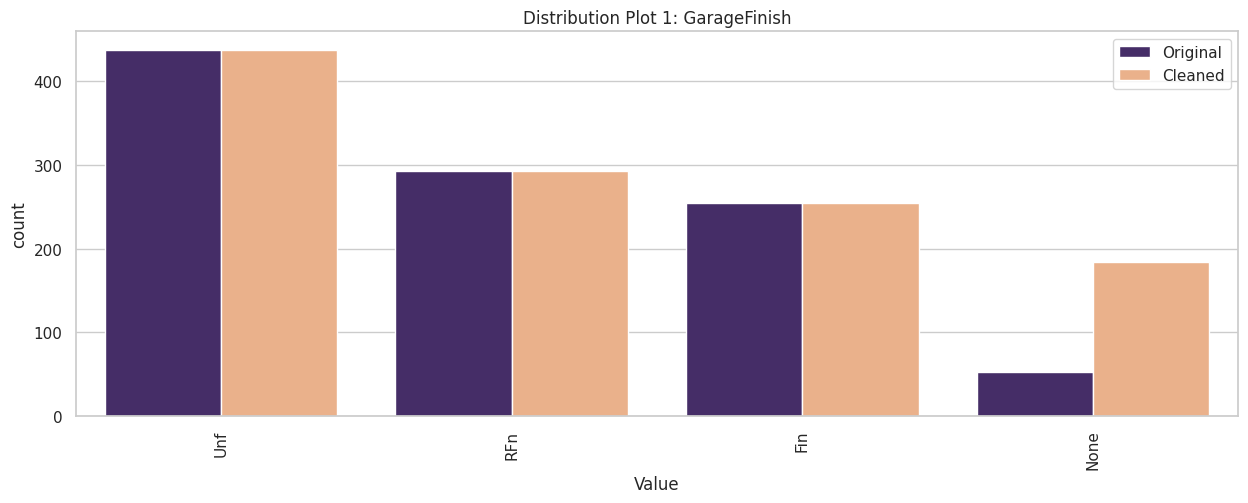

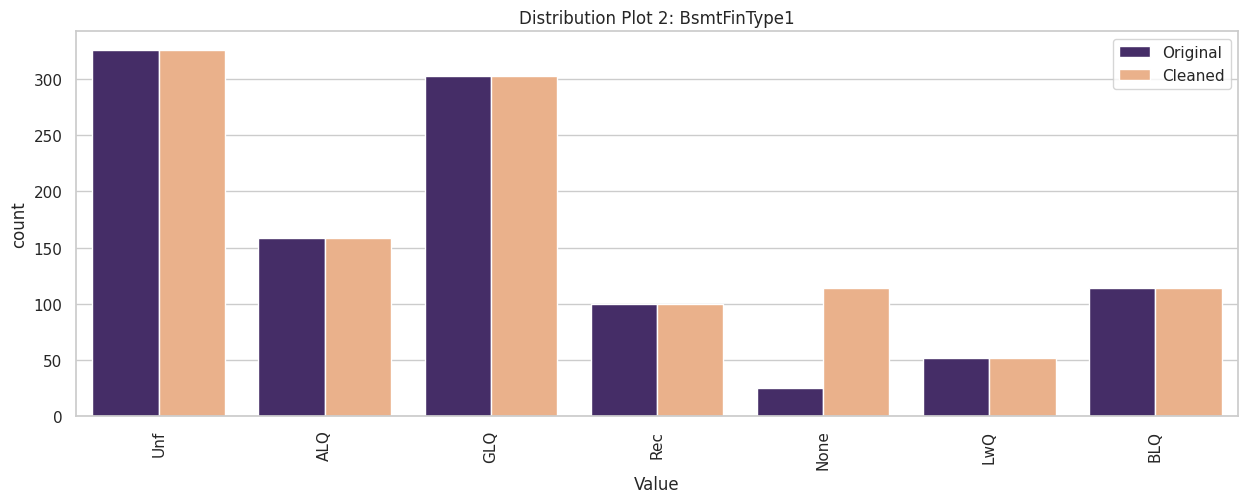

In [16]:
variables_categorical = ['GarageFinish' , 'BsmtFinType1']
imputer = CategoricalImputer(imputation_method='missing', fill_value='None', variables=variables_categorical)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_categorical)

### Numerical data

* We have five numerical variables with missing data:
    * LotFrontage, representing the linear feet of street connected to the property , with 18.15% of missing data.
    * BedroomAbvGr, representing the bedrooms above grade (not including basement bedrooms) , with 6.85% of missing data.
    * 2ndFlrSF, representing the second floor square footage, with 5.14% of missing data.
    * GarageYrBlt, representing the year the garage was built, with 4.97% of missing data.
    * MasVnrArea, representing the Masonry veneer area in square feet, with 0.51% of missing data.
* As we are dealing with numerical values, we will use a Mean Median Imputer to replace missing data by the mean or median value of the variable. In order to assess if we will choose the mean or the median, we will see if the variables' distribution is normal.

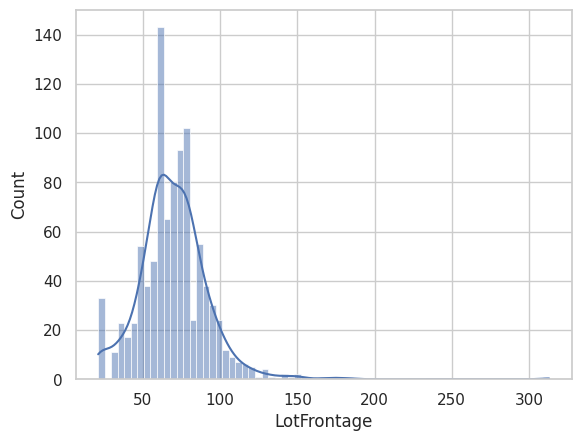

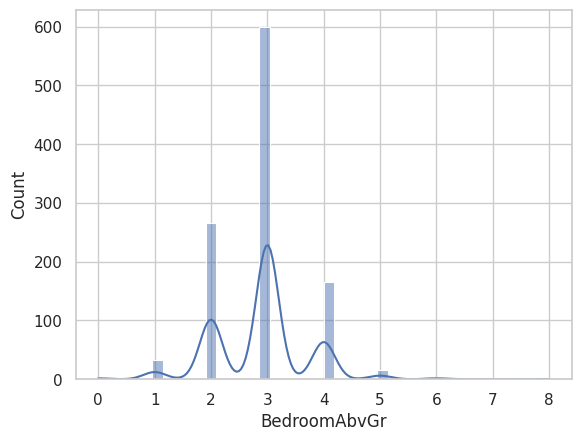

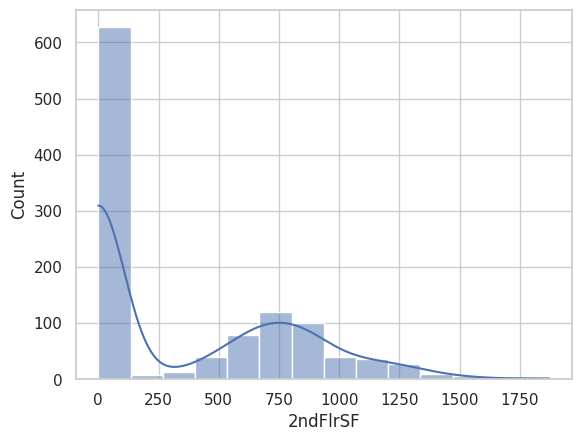

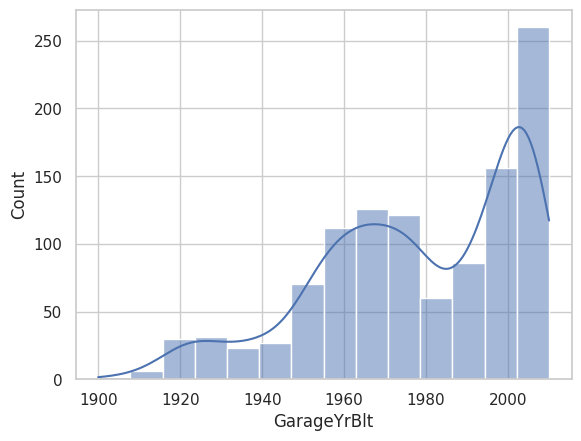

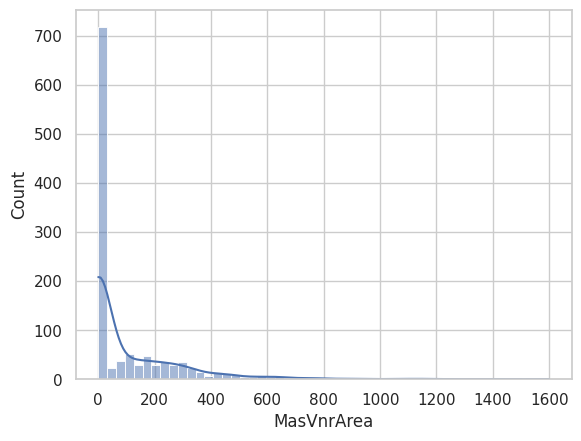

In [17]:
for col in ['LotFrontage' , 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']:
  sns.histplot(data=TrainSet, x=col, kde=True)
  plt.show()

* As we can see from these histogram plots, LotFrontage and BedroomAbvGr have a bell shaped distribution which indicates they are normally distributed and we can use mean imputation.
* The rest of the variables, 2ndFlrSF, GarageYrBlt adn MasVnrArea are skewed, either to the right or to the left. We will therefore use the median as the mean is affected by outlier values and may not be as representative of our data.

#### Mean imputation and visualisation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr'] 




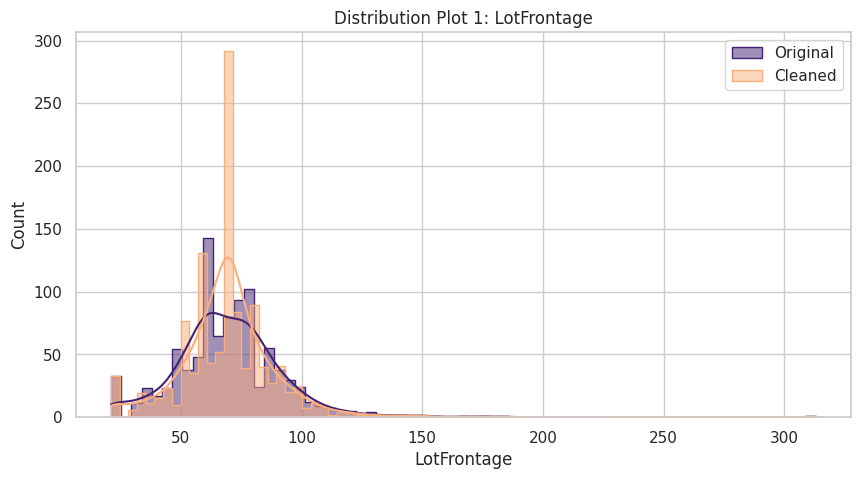

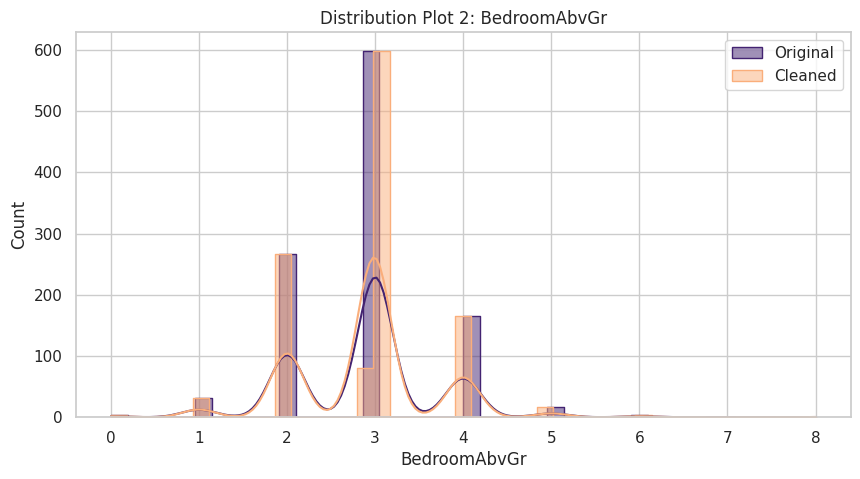

In [18]:
variables_mean = ['LotFrontage' , 'BedroomAbvGr']
imputer = MeanMedianImputer(imputation_method='mean', variables=variables_mean)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_mean)

#### Median imputation and visualisation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




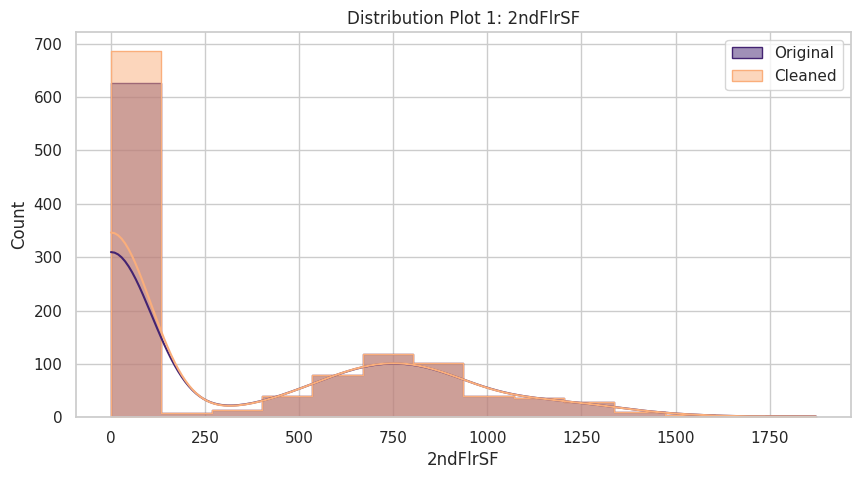

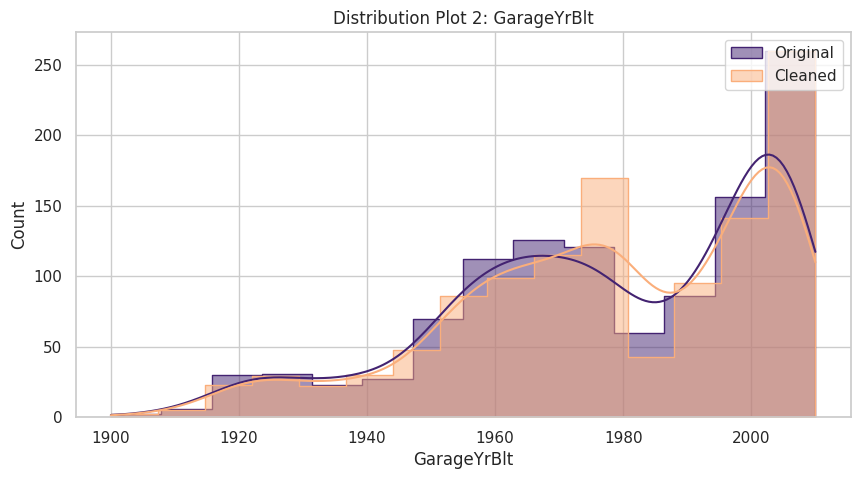

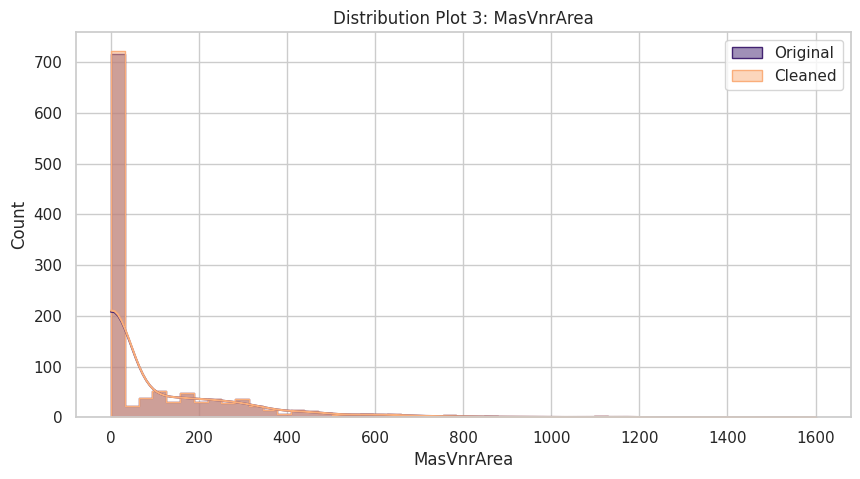

In [19]:
variables_median = ['2ndFlrSF' , 'GarageYrBlt', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_median)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_median)

---

## Arrange cleaning steps in pipeline

* We will arrange our data cleaning steps in a pipeline. This will facilitate the data cleaning of our whole dataset.
* The steps are as follows:
    * Dropping EnclosedPorch and WoodDeckSF variables.
    * Categorical imputation on GarageFinish and BsmtFinType1 variables.
    * Numerical mean imputation on LotFrontage and BedroomAbvGr variables.
    * Numerical median imputation on 2ndFlrSF, GarageYrBlt and MasVnrArea variables.

In [20]:
dataCleaning_pipeline = Pipeline([
    
      ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']) ),
      ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='None',
                                     variables=['GarageFinish' , 'BsmtFinType1']) ),
      ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['LotFrontage' , 'BedroomAbvGr']) ),
      ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']) )
])

* We apply run the whole dataset through the pipeline to clean all our data

In [21]:
TrainSet, TestSet = dataCleaning_pipeline.fit_transform(TrainSet) , dataCleaning_pipeline.fit_transform(TestSet)
df_prices = dataCleaning_pipeline.fit_transform(df_prices)

* We confirm that there is no missing data left in our Train and Test set as well as our dataframe.

In [22]:
VisualizeMissingData(TrainSet)

,DataType,RowsWithMissingData,PercentageOfDataset


In [23]:
VisualizeMissingData(TestSet)

,DataType,RowsWithMissingData,PercentageOfDataset


In [24]:
VisualizeMissingData(df_prices)

,DataType,RowsWithMissingData,PercentageOfDataset


---

# Push files to Repo

* We push our Train, Test and cleaned data sets to the repo

In [25]:
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)
df_prices.to_csv("outputs/datasets/cleaned/HousePricesCleaned.csv", index=False)


* And we save our pipeline in case of further use (such as cleaning the inherited houses data).

In [26]:
file_path = f'outputs/ml_pipeline/data_cleaning'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [27]:
joblib.dump(value=dataCleaning_pipeline, filename=f"{file_path}/dataCleaning_pipeline.pkl")

['outputs/ml_pipeline/data_cleaning/dataCleaning_pipeline.pkl']